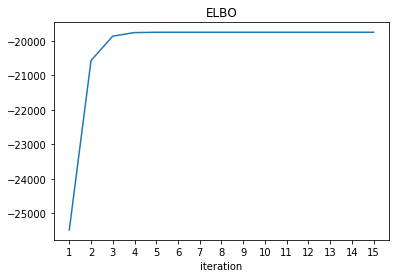

In [2]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123123123)

# Compute ELBO for the model described in simple_elbo.pdf
def compute_elbo(alpha_tau, beta_tau, r1, r2, m2, beta2, alpha0, beta0, x):
    
    from scipy.special import psi, gammaln # digamma function, logarithm of gamma function
    
    # E[log p(tau)]
    term1 = (alpha0 - 1) * (psi(alpha_tau) + psi(beta_tau) - 2 * psi(alpha_tau + beta_tau))

    # E[log p(theta)]
    term2 = -1/2 * beta0 * ( beta2**(-1) + m2**2)# EXERCISE

    # E[log p(z|tau)]
    N2 = np.sum(r2); N1 = np.sum(r1); N = N1 + N2
    term3 = N2 * psi(alpha_tau) + N1 * psi(beta_tau) - N * psi(alpha_tau + beta_tau)

    # E[log p(x|z,theta)]
    term4 = -N/2 * np.log(2*np.pi) - 1/2 * np.sum(r1 * x**2) - 1/2 * np.sum(r2 *((x - m2)**2 + beta2**(-1) )) # EXERCISE

    # Negative entropy of q(z)
    term5 = np.sum(r1 * np.log(r1)) + np.sum(r2 * np.log(r2))

    # Negative entropy of q(tau)
    term6 = (gammaln(alpha_tau + beta_tau) - gammaln(alpha_tau) - gammaln(beta_tau)
        + (alpha_tau - 1) * psi(alpha_tau) + (beta_tau - 1) * psi(beta_tau)
        - (alpha_tau + beta_tau - 2) * psi(alpha_tau + beta_tau))

    # Negative entropy of q(theta)
    term7 = -1/2 * np.log(2*np.pi*np.e* beta2**(-1))# EXERCISE

    elbo = term1 + term2 + term3 + term4 - term5 - term6 - term7
    
    return elbo


# Simulate data
theta_true = 4
tau_true = 0.3
n_samples = 10000
z = (np.random.rand(n_samples) < tau_true)  # True with probability tau_true
x = np.random.randn(n_samples) + z * theta_true

# Parameters of the prior distributions.
alpha0 = 0.5
beta0 = 0.2

n_iter = 15 # The number of iterations
elbo_array = np.zeros(n_iter) # To track the elbo

# Some initial value for the things that will be updated
E_log_tau = -0.7   # E(log(tau))
E_log_tau_c = -0.7  # E(log(1-tau))
E_log_var = 4 * np.ones(n_samples)  # E((x_n-theta)^2)
r2 = 0.5 * np.ones(n_samples)  # Responsibilities of the second cluster.

for i in range(n_iter):
    
    # Updated of responsibilites, factor q(z)
    log_rho1 = E_log_tau_c - 0.5 * np.log(2 * np.pi) - 0.5 * (x ** 2)
    log_rho2 = E_log_tau - 0.5 * np.log(2 * np.pi) - 0.5 * E_log_var
    max_log_rho = np.maximum(log_rho1, log_rho2)  # Normalize to avoid numerical problems when exponentiating.
    rho1 = np.exp(log_rho1 - max_log_rho)
    rho2 = np.exp(log_rho2 - max_log_rho)
    r2 = rho2 / (rho1 + rho2)
    r1 = 1 - r2
    
    N1 = np.sum(r1)
    N2 = np.sum(r2)
    
    # Update of factor q(tau)
    from scipy.special import psi # digamma function
    E_log_tau = psi(N2 + alpha0) - psi(N1 + N2 + 2*alpha0)
    E_log_tau_c = psi(N1 + alpha0) - psi(N1 + N2 + 2*alpha0)
    
    # Update of factor q(theta)
    x2_avg = 1 / N2 * np.sum(r2 * x)
    beta_2 = beta0 + N2
    m2 = 1 / beta_2 * N2 * x2_avg
    E_log_var = (x - m2) ** 2 + 1 / beta_2
    
    # Keep track of the current estimates
    tau_est = (N2 + alpha0) / (N1 + N2 + 2*alpha0)
    theta_est = m2
    
    # Compute ELBO
    alpha_tau = N2 + alpha0
    beta_tau = N1 + alpha0
    elbo_array[i] = compute_elbo(alpha_tau, beta_tau, r1, r2, m2, beta_2, alpha0, beta0, x)

# Plot ELBO as a function of iteration
plt.plot(np.arange(n_iter) + 1, elbo_array)
plt.xticks(np.arange(n_iter) + 1)
plt.xlabel("iteration")
plt.title("ELBO")
plt.show()



True principal axes
[[-2.17126121]
 [ 1.99469089]]


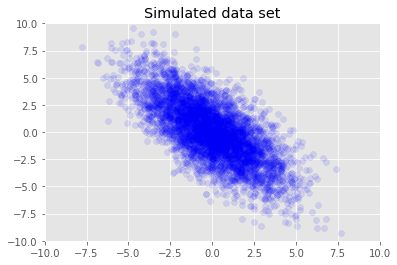

500/500 [100%] ██████████████████████████████ Elapsed: 28s | Loss: 21464.775
Inferred principal axes:
[[ 1.8753159 ]
 [-2.20138454]]
Inferred noise_std
[[ 1.07498813  0.        ]
 [ 0.          1.62018573]]
True noise_std
[[ 0.32089966  0.        ]
 [ 0.          1.90115179]]


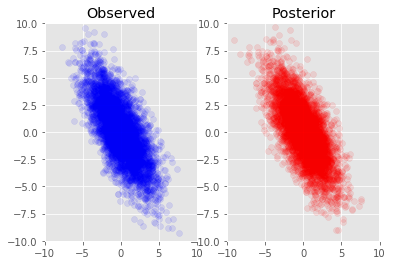

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

np.random.seed(123)
plt.close('all')
plt.style.use('ggplot')

def build_toy_dataset(N, D, K):
    x_train = np.zeros((D, N))
    w = np.random.normal(0.0, 2.0, size=(D, K))
    z = np.random.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    psi = np.exp(np.random.normal(size = D)) # ?
    epsilon = np.diag(psi) # ?
    for d in range(D):
        for n in range(N):
            x_train[d, n] = np.random.normal(mean[d, n], epsilon[d,d]) # ?

    print('True principal axes')
    print(w)
    return x_train, epsilon

N = 5000
D = 2 # Data dimension
K = 1 # Latent dimension

x_train, true_noise_std = build_toy_dataset(N, D, K)

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title('Simulated data set')
plt.show()

# MODEL
np.random.seed(123)
noise_std = tf.diag(tf.sqrt(tf.exp(tf.Variable(tf.random_normal(shape=[D]))))) #?
w = Normal(loc=tf.zeros([D, K]), scale=2.0 * tf.ones([D, K])) # prior on w
z = Normal(loc=tf.zeros([N, K]), scale=tf.ones([N, K])) # prior on z 
x = Normal(loc=tf.matmul(w, z, transpose_b=True), scale= noise_std @ tf.ones([D,N])) # likelihood # ?
# transpose_b=True transposes the second argument


# INFERENCE
qw = Normal(loc=tf.Variable(tf.random_normal([D, K])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qz = Normal(loc=tf.Variable(tf.random_normal([N, K])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([N, K]))))

inference = ed.KLqp({w: qw, z: qz}, data={x: x_train}) # Note: noise std is not updated
inference.run(n_iter=500, n_print=100, n_samples=10)

# CRITICISM
print('Inferred principal axes:')
print(qw.mean().eval())

x_post = ed.copy(x, {w: qw, z: qz}) # Simulate x_post similarly to x, but use learned z and w
x_gen = x_post.sample().eval()

print('Inferred noise_std')
print(noise_std.eval())

print('True noise_std')
print(true_noise_std)

# VISUALIZATION
def visualise(x_data, y_data, ax, color, title):
    ax.scatter(x_data, y_data, color=color, alpha=0.1)
    ax.axis([-10, 10, -10, 10])
    ax.set_title(title)
    
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

visualise(x_train[0, :], x_train[1, :], ax1, 'blue', 'Observed')
visualise(x_gen[0, :], x_gen[1, :], ax2, 'red', 'Posterior')

plt.show()

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

np.random.seed(123)
plt.close('all')
plt.style.use('ggplot')

def build_toy_dataset(N, D, K, sigma=1.3):
    x_train = np.zeros((D, N))
    w = np.random.normal(0.0, 2.0, size=(D, K))
    z = np.random.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    for d in range(D):
        for n in range(N):
            x_train[d, n] = np.random.normal(mean[d, n], sigma)

    print('True principal axes')
    print(w)
    return x_train, sigma

N = 5000
D = 2 # Data dimension
K = 1 # Latent dimension

x_train, true_noise_std = build_toy_dataset(N, D, K)


# MODEL
noise_std = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))
w = Normal(loc=tf.zeros([D, K]), scale=2.0 * tf.ones([D, K])) # prior on w
z = Normal(loc=tf.zeros([N, K]), scale=tf.ones([N, K])) # prior on z 
x = Normal(loc=tf.matmul(w, z, transpose_b=True), scale=tf.ones([D, N]) * noise_std) # likelihood
# transpose_b=True transposes the second argument


# INFERENCE
qw = Normal(loc=tf.Variable(tf.random_normal([D, K])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qz = Normal(loc=tf.Variable(tf.random_normal([N, K])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([N, K]))))

inference = ed.KLqp({w: qw, z: qz}, data={x: x_train}) # Note: noise std is not updated
inference.run(n_iter=500, n_print=100, n_samples=10)


# CRITICISM
print('Inferred principal axes:')
print(qw.mean().eval())

x_post = ed.copy(x, {w: qw, z: qz}) # Simulate x_post similarly to x, but use learned z and w
x_gen = x_post.sample().eval()

print('Inferred noise_std')
print(noise_std.eval())

print('True noise_std')
print( true_noise_std)

# VISUALIZATION
def visualise(x_data, y_data, ax, color, title):
    ax.scatter(x_data, y_data, color=color, alpha=0.1)
    ax.axis([-10, 10, -10, 10])
    ax.set_title(title)
    
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

visualise(x_train[0, :], x_train[1, :], ax1, 'blue', 'Observed')
visualise(x_gen[0, :], x_gen[1, :], ax2, 'red', 'Posterior')

plt.show()

#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
#plt.axis([-10, 10, -10, 10])
#plt.title('Simulated data set')
#plt.show()

True principal axes
[[-2.17126121]
 [ 1.99469089]]
500/500 [100%] ██████████████████████████████ Elapsed: 27s | Loss: 21483.484
Inferred principal axes:
[[ 2.09787989]
 [-1.95170796]]
Inferred noise_std
1.34053
True noise_std
1.3


<Figure size 640x480 with 2 Axes>

In [4]:
#!pip install edward==1.3.5
#!pip install tensorflow==1.4.1

    100% |████████████████████████████████| 41.2MB 514kB/s eta 0:00:01
    100% |████████████████████████████████| 1.7MB 6.3MB/s eta 0:00:01
gpflow 1.3.0 has requirement tensorflow>=1.5.0, but you'll have tensorflow 1.4.1 which is incompatible.
  Found existing installation: tensorflow-tensorboard 1.5.1
    Uninstalling tensorflow-tensorboard-1.5.1:
      Successfully uninstalled tensorflow-tensorboard-1.5.1
  Found existing installation: tensorflow 1.10.0
    Uninstalling tensorflow-1.10.0:
      Successfully uninstalled tensorflow-1.10.0
